In [4]:
import numpy as np
import os
import torch
from multiprocessing import Pool

from dawgz import job, after, ensure, schedule
from itertools import starmap
from pathlib import Path
from typing import *

from lampe.data import JointLoader, H5Dataset
from zuko.distributions import BoxUniform

import sys
# sys.path.insert(0, '/home/mvasist/Highres/') #WISEJ1738/sbi' WISEJ1738.sbi.
from parameter import *
from spectra_simulator import SpectrumMaker 
from parameter_set_script import param_set, param_list, param_list_ext, param_set_ext, deNormVal

from ProcessingSpec import ProcessSpec
# sys.path.insert(0, '/home/mvasist/Highres/') #WISEJ1738/sbi' WISEJ1738.sbi.
from DataProcuring import Data

from torch.utils.data import DataLoader, Dataset, IterableDataset

import GISIC
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


LABELS, LOWER, UPPER = zip(*[
[                  r'$FeH$',  -1.5, 1.5],   # temp_node_9
[                  r'$CO$',  0.1, 1.6],  # CO_mol_scale
[                  r'$\log g$',   2.5, 5.5],          # log g
[                  r'$Tint$',  300,   3500],   # temp_node_5
[                  r'$T1$',  300,   3500],      # T_bottom
[                  r'$T2$',  300,   3500],   # temp_node_1
[                  r'$T3$',  300,   3500],   # temp_node_2
[                  r'$alpha$',  1.0, 2.0],   # temp_node_4
[                  r'$log_delta$', 3.0, 8.0],   # temp_node_3
[                  r'$log_Pquench$', -6.0, 3.0],   # temp_node_6
[                  r'$logFe$',  -2.3, 1.0], # CH4_mol_scale
[                  r'$fsed$',  0.0, 10.0],   # temp_node_8
[                  r'$logKzz$',  5.0, 13.0], # H2O_mol_scale \_mol\_scale
[                  r'$sigmalnorm$',  1.05, 3.0], # C2O_mol_scale
[                  r'$log\_iso\_rat$',  -11.0, -1.0],   # temp_node_7
[                  r'$R\_P$', 0.8, 2.0],             # R_P / R_Jupyter
[                  r'$rv$',  20.0, 35.0], # NH3_mol_scale
[                  r'$vsini$',  10.0, 30.0], # H2S_mol_scale
[                  r'$limb\_dark$',  0.0, 1.0], # PH3_mol_scale
])

processing = ProcessSpec()
d = Data()

# FeH, CO, log_g, T_int, T1, T2, T3, alpha, log_delta, log_Pquench, Fe, fsed, Kzz, sigma_lnorm, iso_rat , 
# radius, rv, vsini, limb_dark

scratch = os.environ.get('GLOBALSCRATCH', '')
path = Path(scratch) / 'Highres/simulations/'
path.mkdir(parents= True, exist_ok=True)

def simulator(theta): 
    values_actual = theta[:-4].numpy()
    values_ext_actual = theta[-4:].numpy()
    
    sim = SpectrumMaker(wavelengths=d.model_wavelengths, param_set=param_set, lbl_opacity_sampling=2)
    spectrum = sim(values_actual)
    spec = np.vstack((np.array(spectrum), d.model_wavelengths))
    th, x = processing(torch.from_numpy(np.array([values_actual])), torch.from_numpy(np.array(spec)), \
                       sample= False, \
                       values_ext_actual= torch.from_numpy(np.array([values_ext_actual])))
    return x.squeeze()

prior = BoxUniform(torch.tensor(LOWER), torch.tensor(UPPER))
loader = JointLoader(prior, simulator, batch_size=16, numpy=False) #the simulator takes actual values

def filter_nan(theta, x):
    # print(theta.shape, x.shape)
    mask = torch.any(torch.isnan(x[:,0]), dim=-1)
    mask += torch.any(~torch.isfinite(x[:,0]), dim=-1)
    return theta[~mask], x[:,0][~mask]

#     H5Dataset.store(
#         starmap(filter_nan, loader),
#         path / f'samples_{i+320:06d}.h5',
#         size=4096*3,
#     )



In [5]:
for th, x in loader :
    thh, xx = filter_nan(th,x)
    break

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.
  Read line opacities of CO_36...
 Done.

  Read CIA opac

In [7]:
import matplotlib.pyplot as plt

In [9]:
thh.size(), xx.size()

(torch.Size([16, 19]), torch.Size([16, 6144]))

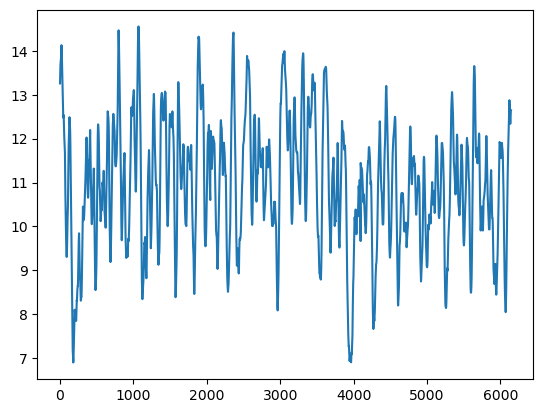

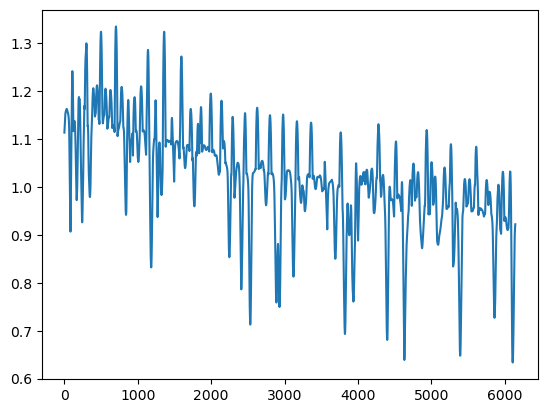

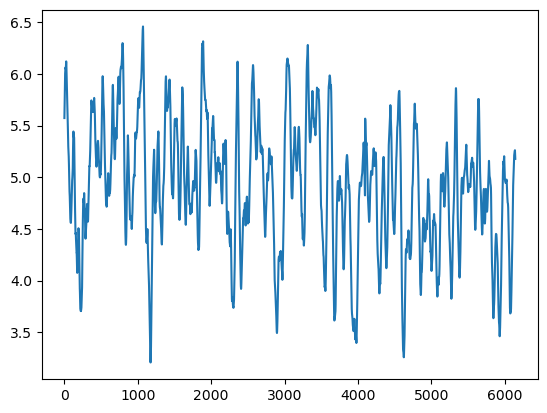

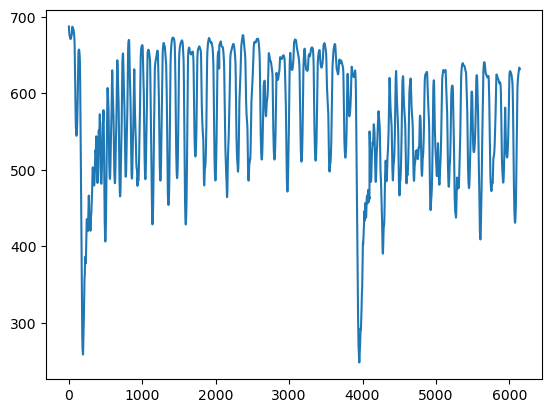

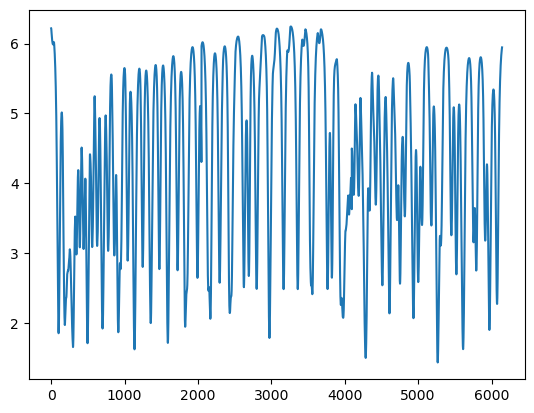

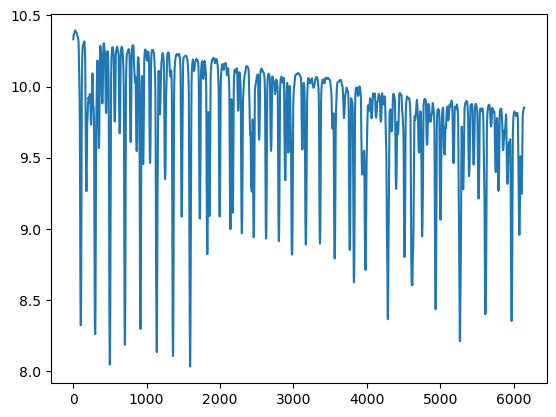

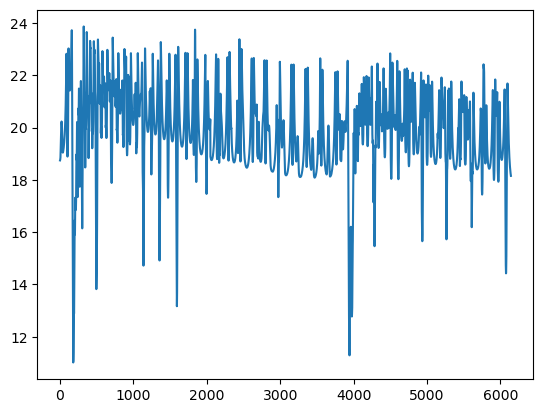

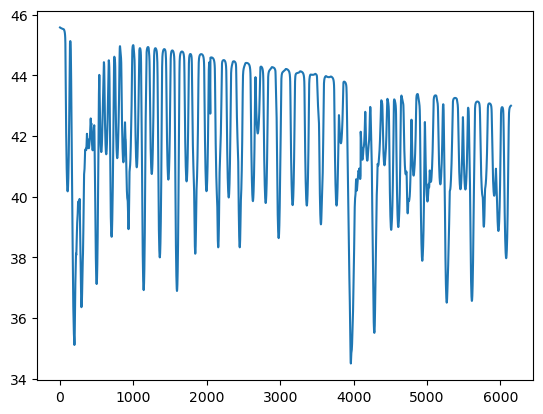

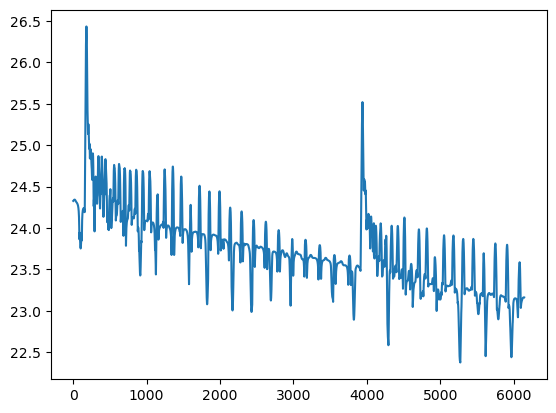

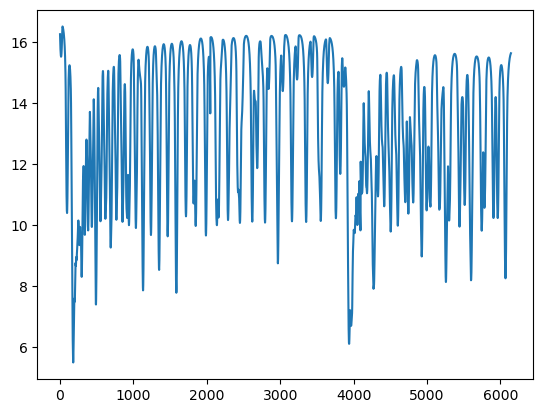

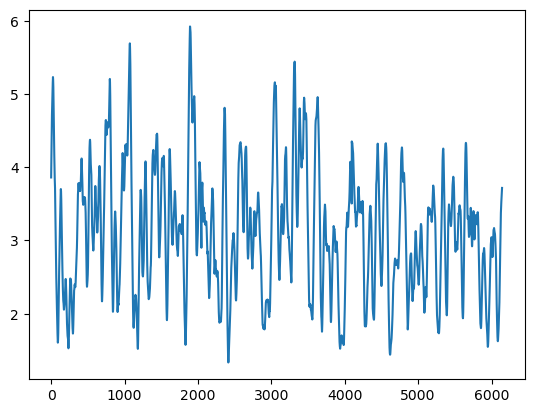

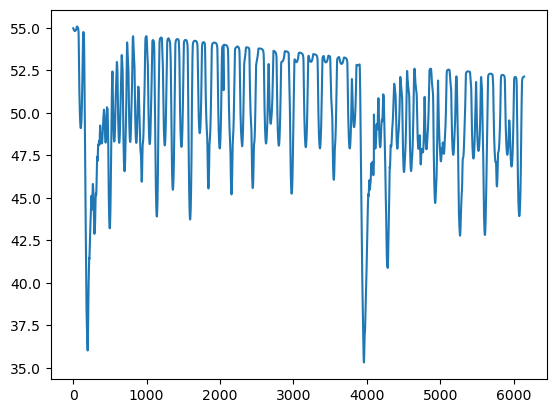

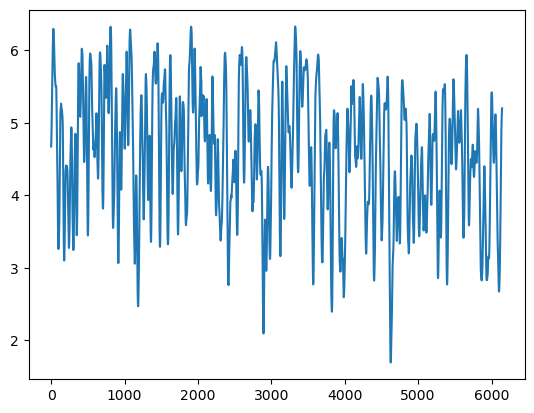

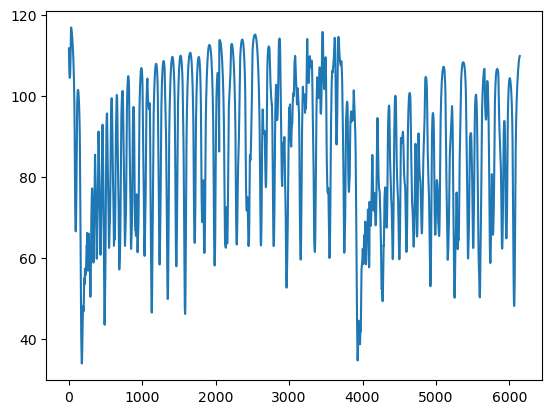

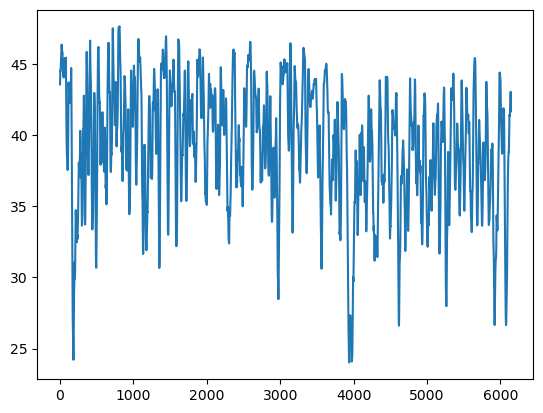

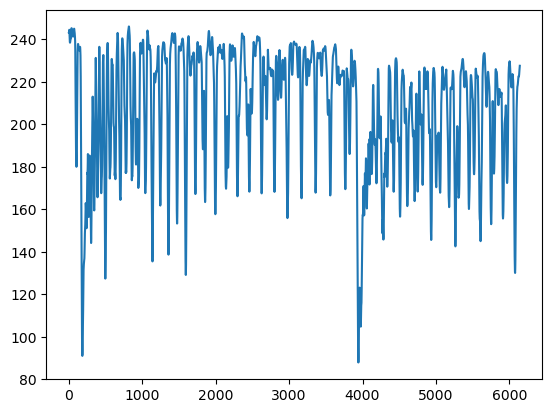

In [13]:
for i in range(16):
    plt.plot(xx[i])
    plt.show()

In [12]:
thh

tensor([[ 9.7880e-01,  7.7366e-01,  2.9106e+00,  2.8423e+03,  1.5792e+03,
          1.1649e+03,  3.7416e+02,  1.4761e+00,  6.6344e+00, -5.8867e+00,
         -8.4617e-01,  6.9332e+00,  5.9031e+00,  1.9920e+00, -3.2960e+00,
          1.6507e+00,  2.0814e+01,  2.4066e+01,  2.5451e-01],
        [-1.1533e+00,  4.6905e-01,  4.0181e+00,  3.3148e+03,  5.0991e+02,
          2.6577e+03,  9.7593e+02,  1.3374e+00,  7.7389e+00, -4.2612e+00,
          4.8490e-01,  7.9453e+00,  1.1303e+01,  2.3230e+00, -1.1422e+00,
          1.7360e+00,  3.2232e+01,  1.8863e+01,  7.6325e-01],
        [-5.3763e-01,  1.4250e-01,  4.1289e+00,  2.6367e+03,  1.0834e+03,
          3.1348e+03,  1.8320e+03,  1.1218e+00,  6.8424e+00, -3.1315e+00,
         -1.6380e+00,  7.5556e+00,  5.2868e+00,  1.1055e+00, -7.1262e+00,
          9.2645e-01,  2.0019e+01,  2.8230e+01,  2.2910e-01],
        [-5.7383e-01,  7.5252e-01,  3.0712e+00,  3.0435e+03,  2.0189e+03,
          1.5013e+03,  3.2380e+03,  1.3355e+00,  3.3128e+00, -5.0511e+00,
